In [2]:
import numpy as np
import pandas as pd

In [2]:
data = pd.read_csv(r"C:\Users\Mahsa\Desktop\base\energy poverty\Residential total final consumption (TFC) by source - Islamic Republic of Iran.csv",
                   skiprows=3)
data.rename(columns={
    "Unnamed: 0" : "year"
}, inplace = True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   year                33 non-null     int64  
 1   Oil products        33 non-null     int64  
 2   Natural gas         33 non-null     int64  
 3   Biofuels and waste  33 non-null     int64  
 4   Electricity         33 non-null     int64  
 5   Coal                30 non-null     float64
 6   Units               33 non-null     object 
dtypes: float64(1), int64(5), object(1)
memory usage: 1.9+ KB


In [19]:
data.head()

,year,Oil products,Natural gas,Biofuels and waste,Electricity,Coal,Units
0,1990,350837,109286,3526,62438,NaN,TJ
1,1991,369349,157915,3777,68860,NaN,TJ
2,1992,425104,245763,4402,70232,NaN,TJ
3,1993,407478,269018,4928,79714,774.0,TJ
4,1994,490043,343683,5500,80902,774.0,TJ


In [20]:
data.columns

Index(['year', 'Oil products', 'Natural gas', 'Biofuels and waste',
       'Electricity', 'Coal', 'Units'],
      dtype='object')

In [21]:
data.dropna(inplace = True)

In [3]:
cols = ['Oil products', 'Natural gas', 'Biofuels and waste', 'Electricity', 'Coal']

# Calculate row totals for just these columns
row_totals = data[cols].sum(axis=1)

# Divide each column by the row total
data[cols] = (data[cols].div(row_totals, axis=0))*100

In [23]:
data.head()

,year,Oil products,Natural gas,Biofuels and waste,Electricity,Coal,Units
3,1993,53.480979,35.308277,0.646794,10.462363,0.101587,TJ
4,1994,53.213371,37.320258,0.597241,8.785082,0.084048,TJ
5,1995,50.411096,40.354146,0.539800,8.615708,0.079250,TJ
6,1996,47.381638,43.665891,0.538724,8.339021,0.074726,TJ
7,1997,44.751484,46.106714,0.423696,8.648003,0.070103,TJ


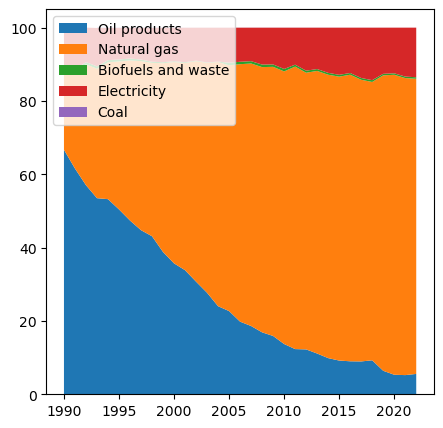

In [4]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(5, 5))

ax.stackplot(data["year"], data[cols].T, labels=cols)

ax.legend(loc='upper left')
plt.show()

In [33]:
data.loc[data["year"]==2022]

,year,Oil products,Natural gas,Biofuels and waste,Electricity,Coal,Units
32,2022,5.552253,80.499857,0.40398,13.530631,0.013278,TJ


# Working on HIES

data = pd.read_